In [1]:
import numpy as np
import random
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from keras.datasets import mnist
from nltk.cluster import KMeansClusterer, euclidean_distance, cosine_distance

In [3]:
def calcManhattanDistance (point1, point2):

    dist = 0
    for p1, p2 in zip(point1,point2):
        dist += abs(p1-p2)
    return dist

def calcConfusionMatrixAcc(matrix):
    
    arr = np.asarray(matrix)
    return float(sum(np.diagonal(arr)))/float(sum(sum(matrix)))

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]* x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]* x_test.shape[2])

x_data = np.concatenate((x_train, x_test))
y_data = np.concatenate((y_train, y_test))
print('Data X Shape:',x_data.shape)
print('Data Y Shape:',y_data.shape)

Data X Shape: (70000, 784)
Data Y Shape: (70000,)


### Part I: Apply PCA to MNIST Data 

Old features: (70000, 784)
Feature after PCA: (70000, 2)


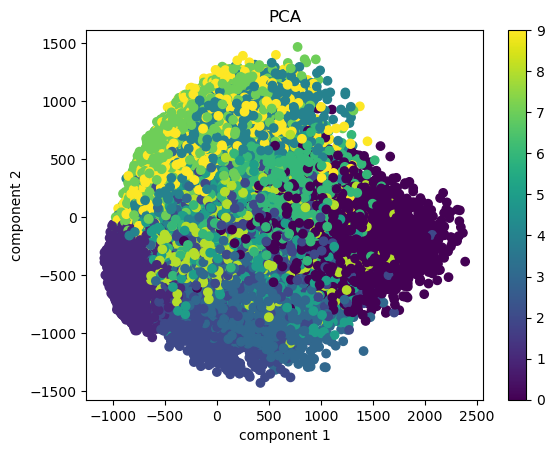

In [7]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(x_data)
print('Old features:',x_data.shape)
print('Feature after PCA:',projected.shape)

plt.scatter(projected[:, 0],projected[:, 1], c=y_data)

plt.title("PCA")
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

### Part II: Clustering

In [11]:
def new_part2(distance_func, X, y, k_value=10):
    
    print('Data Shape:',X.shape,'\n')

    k_folds = KFold(n_splits=5)
    k_fold_index = 1
    
    all_train_y = []
    all_train_pred = []
    all_test_y = []
    all_test_pred = []
    
    for train_index, test_index in k_folds.split(X):
        print(' #########  KFold Step:', k_fold_index,'  #########')

        train_X, test_X = X[train_index], X[test_index]
        train_y, test_y = y[train_index], y[test_index]

        clusterer = KMeansClusterer(k_value, distance_func, repeats=10)
        clusters = clusterer.cluster(train_X, True)

        table = np.zeros((10,10))

        for l,c in zip(train_y, clusters):
            table[l][c] = table[l][c] + 1

        df = pd.DataFrame(data=table, columns = ['C'+str(i) for i in range(k_value)])
        print('Table:\n',df,'\n')

        flatten_table = table.flatten()
        flatten_table[::-1].sort()

        orders = []
        for d in flatten_table:
            ind = np.where(table==d)
            for j in zip(*ind):
                orders.append(j)

        labels_row = {}
        labels_col = {}
        i = 0
        while True:
            row = orders[i][0]
            col = orders[i][1]

            if (not row in labels_row) and (not col in labels_col):
                labels_row[row] = (row,col, table[row][col])
                labels_col[col] = (row,col, table[row][col])

            if len(labels_row) == k_value:
                break

            i = i + 1

        cluster_labels = {}
        for i in range(k_value):
            cluster_labels[labels_row[i][1]] = labels_row[i][0]
            print('Cluster:',labels_row[i][1],' assigned Label:',labels_row[i][0], ' Value:', labels_row[i][2])
        print('\n')

        all_train_y.extend(train_y)
        for c in clusters:
            all_train_pred.append(cluster_labels[c])

        all_test_y.extend(test_y)
        for t in test_X:
            all_test_pred.append(cluster_labels[clusterer.classify(t)])

        k_fold_index = k_fold_index + 1 
    return all_train_y, all_train_pred, all_test_y, all_test_pred


In [19]:

allTrainY1, allTrainGuess1, allTestY1, allTestGuess1 = new_part2(euclidean_distance, projected[:1000], y_data[:1000])

Data Shape: (1000, 2) 

 #########  KFold Step: 1   #########
Table:
      C0    C1    C2    C3    C4    C5    C6    C7    C8    C9
0   0.0   0.0   0.0   0.0   8.0   0.0  24.0   0.0  44.0   0.0
1  72.0  17.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0
2   5.0   4.0  11.0  10.0  19.0   4.0  25.0   1.0   0.0   0.0
3   0.0   6.0  13.0  33.0  13.0   5.0   0.0   0.0   2.0   0.0
4   0.0   4.0   0.0   0.0   3.0  27.0   0.0  25.0   0.0  25.0
5   0.0  18.0   7.0  15.0  20.0   3.0  12.0   1.0   2.0   1.0
6   1.0   8.0   3.0   0.0  27.0   7.0  19.0   0.0   0.0  10.0
7   2.0  10.0   0.0   0.0   1.0  41.0   0.0  28.0   0.0  14.0
8   1.0  11.0  30.0   7.0  19.0   1.0   2.0   0.0   0.0   1.0
9   0.0  11.0   0.0   0.0   4.0  30.0   0.0  24.0   1.0   7.0 

Cluster: 8  assigned Label: 0  Value: 44.0
Cluster: 0  assigned Label: 1  Value: 72.0
Cluster: 6  assigned Label: 2  Value: 25.0
Cluster: 3  assigned Label: 3  Value: 33.0
Cluster: 7  assigned Label: 4  Value: 25.0
Cluster: 1  assigned Label: 5  

In [14]:
print('Euclidean_distance, Train Confusion Matrix Accuracy:', calcConfusionMatrixAcc(confusion_matrix(allTrainY1, allTrainGuess1)))
print('Euclidean_distance, Test Confusion Matrix Accuracy:', calcConfusionMatrixAcc(confusion_matrix(allTestY1, allTestGuess1)))

Euclidean_distance, Train Confusion Matrix Accuracy: 0.4155
Euclidean_distance, Test Confusion Matrix Accuracy: 0.411


In [20]:

allTrainY2, allTrainGuess2, allTestY2, allTestGuess2 = new_part2(cosine_distance, projected[:1000], y_data[:1000])

Data Shape: (1000, 2) 

 #########  KFold Step: 1   #########
Table:
      C0    C1    C2    C3    C4    C5    C6    C7    C8    C9
0   0.0   0.0   1.0   0.0   1.0   3.0   0.0  56.0  15.0   0.0
1  61.0  28.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0
2   8.0   5.0  11.0  12.0   3.0  14.0   1.0  20.0   3.0   2.0
3   4.0   3.0   8.0  32.0   7.0   9.0   2.0   1.0   3.0   3.0
4   0.0   2.0   0.0   0.0  18.0   0.0  29.0   1.0   2.0  32.0
5   4.0  15.0   9.0   6.0   6.0  18.0   0.0  12.0   6.0   3.0
6   6.0   9.0   2.0   4.0   3.0   4.0   4.0  12.0  24.0   7.0
7   1.0  11.0   0.0   0.0  26.0   0.0  37.0   0.0   0.0  21.0
8  14.0   9.0  19.0  12.0   0.0   9.0   1.0   1.0   6.0   1.0
9   0.0   7.0   0.0   1.0  28.0   0.0  26.0   1.0   1.0  13.0 

Cluster: 7  assigned Label: 0  Value: 56.0
Cluster: 0  assigned Label: 1  Value: 61.0
Cluster: 1  assigned Label: 2  Value: 5.0
Cluster: 3  assigned Label: 3  Value: 32.0
Cluster: 9  assigned Label: 4  Value: 32.0
Cluster: 5  assigned Label: 5  V

In [16]:
print('Cosine_distance, Train Confusion Matrix Accuracy:', calcConfusionMatrixAcc(confusion_matrix(allTrainY2, allTrainGuess2)))
print('Cosine_distance, Test Confusion Matrix Accuracy:', calcConfusionMatrixAcc(confusion_matrix(allTestY2, allTestGuess2)))

Cosine_distance, Train Confusion Matrix Accuracy: 0.36775
Cosine_distance, Test Confusion Matrix Accuracy: 0.353


In [21]:
allTrainY3, allTrainGuess3, allTestY3, allTestGuess3 = new_part2(calcManhattanDistance,projected[:1000],y_data[:1000])

Data Shape: (1000, 2) 

 #########  KFold Step: 1   #########
Table:
      C0    C1    C2    C3    C4    C5    C6    C7    C8    C9
0   0.0   0.0   0.0   1.0   0.0   7.0   0.0  24.0  44.0   0.0
1  73.0  16.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0
2   4.0   4.0  14.0  10.0   5.0  22.0   1.0  18.0   1.0   0.0
3   0.0   7.0  18.0  26.0   5.0  15.0   0.0   0.0   1.0   0.0
4   0.0   2.0   0.0   0.0  20.0   3.0  28.0   1.0   0.0  30.0
5   0.0  17.0   5.0  16.0   4.0  21.0   1.0  12.0   2.0   1.0
6   1.0   9.0   2.0   0.0   7.0  25.0   0.0  24.0   0.0   7.0
7   2.0   9.0   0.0   0.0  31.0   1.0  35.0   0.0   0.0  18.0
8   1.0  15.0  25.0   7.0   1.0  20.0   0.0   2.0   0.0   1.0
9   0.0   7.0   0.0   0.0  34.0   3.0  19.0   1.0   0.0  13.0 

Cluster: 8  assigned Label: 0  Value: 44.0
Cluster: 0  assigned Label: 1  Value: 73.0
Cluster: 7  assigned Label: 2  Value: 18.0
Cluster: 3  assigned Label: 3  Value: 26.0
Cluster: 9  assigned Label: 4  Value: 30.0
Cluster: 1  assigned Label: 5  

In [18]:
print('ManhattanDistance, Train Confusion Matrix Accuracy:', calcConfusionMatrixAcc(confusion_matrix(allTrainY3, allTrainGuess3)))
print('ManhattanDistance, Test Confusion Matrix Accuracy:', calcConfusionMatrixAcc(confusion_matrix(allTestY3, allTestGuess3)))

ManhattanDistance, Train Confusion Matrix Accuracy: 0.427
ManhattanDistance, Test Confusion Matrix Accuracy: 0.415


K-Means with manhattan and euclidean distance gives better result on train and test data. Cosine distance gives worst result on test and train.